# Actor-Critic Single Agent Design

We build on the starter code developed by Chris Lamb (fellow student at UCSD), which is based on PyTorch's sample Reinforcement Learning (RL) code for CartPole. Chris Lamb utilizes temperature to overcome the local optima problems we encountered while implementing REINFORCE and Actor-Critic agents using PyTorch's sample codes for RL: https://github.com/LUKELIEM/reinforce

Chris' starter code has the following Actor-Critic Policy: [actor_critic_model.py](./actor_critic_model.py)

```python
# 4x3x80x80 input # Stack of 4 Atari game frames  

Policy(  
  (features): Sequential(  
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))  
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)  
    (2): ReLU(inplace)  
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))  
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (5): ReLU(inplace)  
  )  
  (action_head): Linear(in_features=256, out_features=6)  
  (value_head): Linear(in_features=256, out_features=1)  
)  

Action = softmax(action_head(x)/temperature)    
Value = value_head(x)
```  
learning rate = 1e-3

In this Notebook, we progressively evolve this into a Conv-LSTM network utilizing Truncated Backprop Thru Time (TBPTT). We apply the network on the two Atari games of Pong and Breakout.

## Key Findings

### Hyperparameters

* Temperature should be maintained above 1.0 for as long as possible in order to push the agent towards exploring. If Temperature is set to 1.0 or below too early, the agent will be content staying at a local optima. The analog to this local optima is one of the outer rings surrounding the dominant policy in the Policy Contour we describe in the last section of this Notebook.

* The learning rate is a key hyperparameter. We discover that for our network, a higher learning rate (1e-3) get the agent to achieve human performance very fast, but it can plateau at a lower best performance. On the other hand, a lower learning rate (1e-4) can allow the agent to achieve a higher final running reward, even though it has a slower start in the beginning.

### Gradient Clipping

* While LSTM can handle gradient vanishing, it does not prevent gradient from exploding during a long training sequence in policy-based RL. We noticed that the gradient norm (outputted by torch.nn.utils.clip_grad_norm) can be as high as 10000, so we clip the gradient with max_norm=80000. In this way, gradient clipping does not slow down learning (by annealing gradient update) while preventing the gradient from exploding.


### Truncated Backprop Thru Time

* In general, the agent learns better with higher chunk size (256 --> 768). We believe a large enough chunk size can allow the agent to learn as well as backprop through episode, but we have not tested that out fully.

* TBPTT has the additional benefit of limiting the GPU memory to 1/2-1/3 of the memory demands of backprop through episode.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import os
import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.3


## Actor-Critic Model with LSTM (First Try)

Network Architecture:  [ac_lstm_model.py](./ac_lstm_model.py)

```python
# 4x3x80x80 input # Stack of 4 Atari game frame  

Policy(  
  (features): Sequential(  
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))  
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)  
    (2): ReLU(inplace)  
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))  
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (5): ReLU(inplace)  
    (6): Conv2d (32, 32, kernel_size=(4, 4), stride=(2, 2))  
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (8): ReLU(inplace)  
  )  
  (lstm): LSTMCell(512, 256)  
  (action_head): Linear(in_features=256, out_features=6)  
  (value_head): Linear(in_features=256, out_features=1)  
)  

Action = softmax(action_head(x)/temperature)    
Value = value_head(x)
```
learning rate = 1e-4  (This seems to be the safest working learning rate).

Python code is located in [actor_critic_lstm.py](./actor_critic_lstm.py)

In [35]:
class Policy(torch.nn.Module):

    def __init__(self, input_channels, num_actions):
        super(Policy, self).__init__()
        self.temperature = 1.0
        self.input_channels = input_channels
        self.num_actions = num_actions
        self.features = self._init_features()
        self.lstm = self._init_lstm()
        self.action_head = self._init_action_head()
        self.value_head = self._init_value_head()
        
        self.saved_actions = []
        self.rewards = []

    def _init_features(self):
        layers = []
        # 80 x 80 x in_channels initial dimensions 3D array
        layers.append(torch.nn.Conv2d(self.input_channels,
                                      16, kernel_size=8, stride=4, padding=2))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # 20 x 20 x 16 feature maps
        layers.append(torch.nn.Conv2d(16,
                                      32, kernel_size=4, stride=2, padding=1))
        layers.append(torch.nn.BatchNorm2d(32))
        layers.append(torch.nn.ReLU(inplace=True))
        # 10 x 10 x 32 feature maps
        layers.append(torch.nn.Conv2d(32,
                                      32, kernel_size=4, stride=2, padding=0))
        layers.append(torch.nn.BatchNorm2d(32))
        layers.append(torch.nn.ReLU(inplace=True))
        # 4 x 4 x 32 feature maps
        return torch.nn.Sequential(*layers)
    
    def _init_lstm(self):
        return torch.nn.LSTMCell(32*4*4, 256)

    def _init_action_head(self):
        return torch.nn.Linear(256, self.num_actions)

    def _init_value_head(self):
        return torch.nn.Linear(256, 1)

    def forward(self, inputs):
        x, (hx, cx) = inputs
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 512(4x4x32)
        
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        
        action = torch.nn.functional.softmax(self.action_head(x) /
                                             self.temperature, dim=-1)
        value = self.value_head(x)
        return action, value, (hx, cx)


### Dimension Check

For building the architecture.

In [36]:
model = Policy(4,6)
print (model)
    
x = torch.randn(1,4,80,80)
cx = Variable(torch.zeros(1, 256))
hx = Variable(torch.zeros(1, 256))

action, value, (hx, cx) = model((Variable(x), (hx, cx)))        # Feed it through the model! 

print (ans.shape)
print (value.shape)
print (hx.shape)
print (cx.shape)


Policy(
  (features): Sequential(
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): Conv2d (32, 32, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
  )
  (lstm): LSTMCell(512, 256)
  (action_head): Linear(in_features=256, out_features=6)
  (value_head): Linear(in_features=256, out_features=1)
)
torch.Size([1, 512])
torch.Size([1, 1])
torch.Size([1, 256])
torch.Size([1, 256])


## Result

The Actor-Critic-LSTM achieves human performance in the game of Pong at approx 4000 episodes. The model created by Chris Lamb (without the LSTM) attains human performance at approx. 7000 episodes.

The model learns to running reward of 16.0 by the 9000 episodes. Its performance then crashed likely due to exploding gradient. This is because the current algorithm perform forward and backward prop through an entire game episode. In the game of Pong, there can be over 10000 game steps in a single episode.

We train another model with lr=1e-4 and gradient clipping (max_norm=80000). Eventually it achieves even higher long term performance of 18.1 but after many more episodes. We believe this may be due to a limit we set for maximum number of game steps per episode.

Maximum Running Reward: 16.176
Episode achieving max. Running Reward: 9327
Human Performance: 9.300
Episode achieving Human Performance: 4467


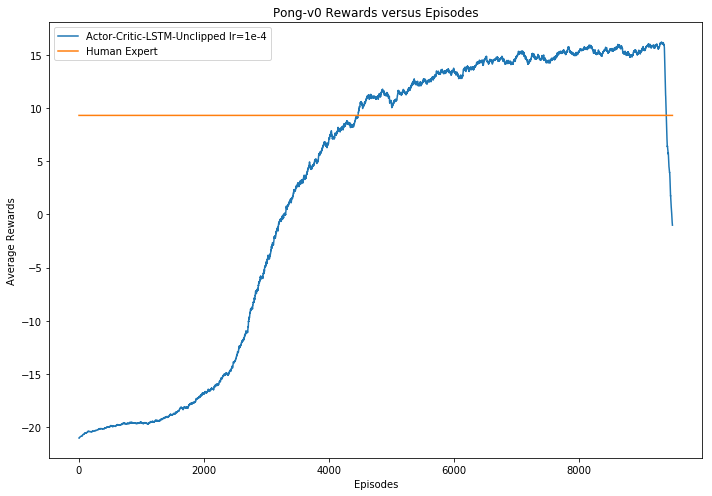

In [3]:
import matplotlib.pyplot as plt
import pickle
import argparse

human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0(AC-lstm-fullepisode-ep=9500).p'.format(game)


with open(data_file, 'rb') as f:
    data = pickle.load(f)

human = [human_scores[game] for _ in range(len(data))]

print('Maximum Running Reward: {:.3f}'.format(max(data)))
print('Episode achieving max. Running Reward: {}'.format(data.index(max(data))))
print('Human Performance: {:.3f}'.format(human_scores[game]))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data) if v > human_scores[game]][0]))

plt.figure(figsize=(10, 7))
plt.plot(data, label='Actor-Critic-LSTM-Unclipped lr=1e-4')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

Maximum Running Reward (AC-No LSTM lr=1e-3): 11.210
Episode achieving max. Running Reward: 14497
Episode achieving Human Performance: 7485
Maximum Running Reward (AC-LSTM lr=1e-3 Clipped): 14.199
Episode achieving max. Running Reward: 10666
Episode achieving Human Performance: 1532
Maximum Running Reward (AC-LSTM lr=1e-4 Unclipped): 16.176
Episode achieving max. Running Reward: 9327
Episode achieving Human Performance: 4467
Maximum Running Reward (AC-LSTM lr=1e-4 Clipped): 18.939
Episode achieving max. Running Reward: 56896
Episode achieving Human Performance: 6371
Human Performance: 9.300


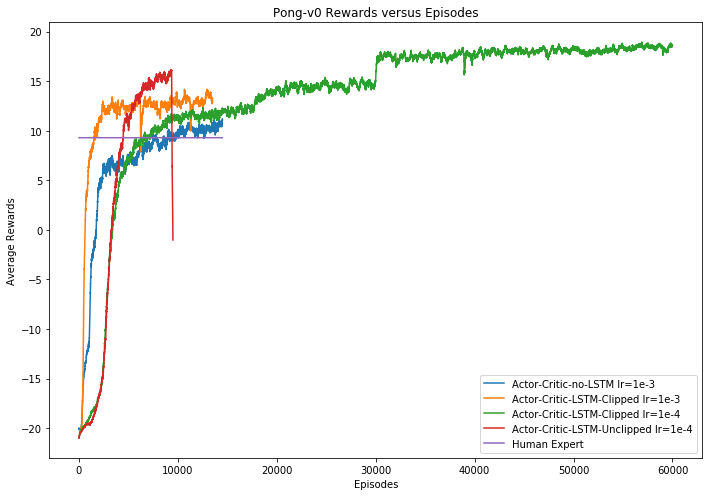

In [4]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0(AC-lstm-fullepisode-ep=9500).p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

data_file = './results/Pong-v0-chris.p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/Pong-v0.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)
    
data_file = './results/Pong-v0 (ACL-episode-lr=1e-3-ep=13500).p'.format(game)

with open(data_file, 'rb') as f:
    data_4 = pickle.load(f)
    

print('Maximum Running Reward (AC-No LSTM lr=1e-3): {:.3f}'.format(max(data_2)))
print('Episode achieving max. Running Reward: {}'.format(data_2.index(max(data_2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_2) if v > human_scores[game]][0]))

print('Maximum Running Reward (AC-LSTM lr=1e-3 Clipped): {:.3f}'.format(max(data_4)))
print('Episode achieving max. Running Reward: {}'.format(data_4.index(max(data_4))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_4) if v > human_scores[game]][0]))

print('Maximum Running Reward (AC-LSTM lr=1e-4 Unclipped): {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_1) if v > human_scores[game]][0]))

print('Maximum Running Reward (AC-LSTM lr=1e-4 Clipped): {:.3f}'.format(max(data_3)))
print('Episode achieving max. Running Reward: {}'.format(data_3.index(max(data_3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_3) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))

human = [human_scores[game] for _ in range(len(data_2))]

plt.figure(figsize=(10, 7))

plt.plot(data_2, label='Actor-Critic-no-LSTM lr=1e-3')
plt.plot(data_4, label='Actor-Critic-LSTM-Clipped lr=1e-3')
plt.plot(data_3, label='Actor-Critic-LSTM-Clipped lr=1e-4')
plt.plot(data_1, label='Actor-Critic-LSTM-Unclipped lr=1e-4')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/ACL-vs-AC-Pong.png")
plt.show()

## Actor-Critic-LSTM (Backprop thru Episode)

Network Architecture is the same:  [ac_lstm_model.py](./ac_lstm_model.py)

We implement 2 major improvements:
* [gradient clipping](http://pytorch.org/docs/master/_modules/torch/nn/utils/clip_grad.html)  
* Temperature annealing - Temp starts at 1.8 and slowing anneal down to 1.0 (to a max of 50000 episode)  

### Rationale for Gradient Clipping
In policy gradient method, we need to forward and backward prop through a game episode, which can exceed 8000 game steps. While LSTM can handle gradient vanishing, it will not prevent gradient from exploding with such a long sequence. 

We noticed that the gradient norm (outputted by torch.nn.utils.clip_grad_norm) can be as high as 10000, so we clip the gradient with max_norm=80000. In this way, gradient clipping does not slow down learning (by annealing gradient update) but prevents the gradient from exploding. 

Python code is located in [actor_critic_lstm-episode.py](./actor_critic_lstm-episode.py)

## Overclipped vs Just Right

There is a technique to gradient clipping!!!  

The chart below demonstrates two scenario:

* Overslipped - when we set max_norm to 1000, agent learning slows down significantly.  
* Gradient Clipping with very high max-norm (80000)

The original AC-LSTM with no gradient clipping learns slower but attains a higher running reward of 16.0. The AC-LSTM with gradient clipping at high max-norm attains human performance faster but start plateauing at 13.0  


Max. Running Reward (AC-LSTM lr=1e-4 unclipped): 16.176
Max. Running Reward (AC-LSTM lr=1e-4 overclipped): 5.454
Max. Running Reward (AC-LSTM lr=1e-3 clipped): 14.199
Max. Running Reward (AC-LSTM lr=1e-4 clipped): 18.939
Human Performance: 9.300


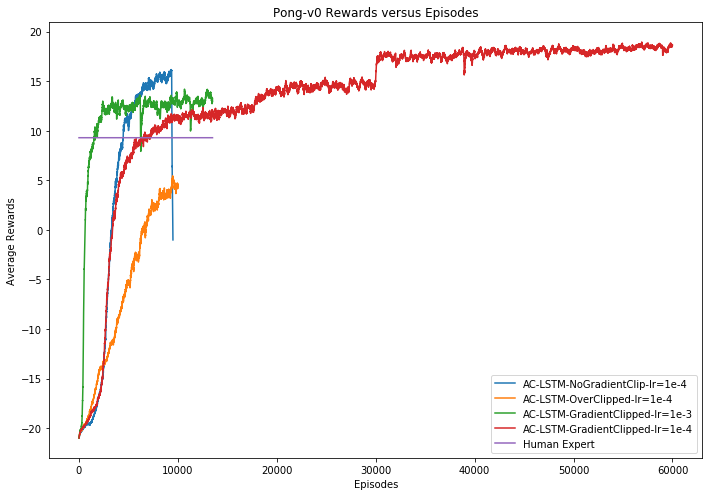

In [5]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0(AC-lstm-fullepisode-ep=9500).p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

data_file = './results/Pong-v0(AC-lstm-episode-overclip-ep=10000).p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/Pong-v0 (ACL-episode-lr=1e-3-ep=13500).p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)
    
data_file = './results/Pong-v0.p'.format(game)

with open(data_file, 'rb') as f:
    data_4 = pickle.load(f)
    
print('Max. Running Reward (AC-LSTM lr=1e-4 unclipped): {:.3f}'.format(max(data_1)))
print('Max. Running Reward (AC-LSTM lr=1e-4 overclipped): {:.3f}'.format(max(data_2)))
print('Max. Running Reward (AC-LSTM lr=1e-3 clipped): {:.3f}'.format(max(data_3)))
print('Max. Running Reward (AC-LSTM lr=1e-4 clipped): {:.3f}'.format(max(data_4)))
print('Human Performance: {:.3f}'.format(human_scores[game]))

human = [human_scores[game] for _ in range(len(data_3))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-LSTM-NoGradientClip-lr=1e-4')
plt.plot(data_2, label='AC-LSTM-OverClipped-lr=1e-4')
plt.plot(data_3, label='AC-LSTM-GradientClipped-lr=1e-3')
plt.plot(data_4, label='AC-LSTM-GradientClipped-lr=1e-4')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Learning Rate

We tried 2 different learning rate for Pong:

* 1e-3
* 1e-4

For our network, a higher learning rate (1e-3) get the agent to achieve human performance very fast, but the final level it plateaus at is lower. On the other hand, a lower learning rate (1e-4) will allow the agent to achieve a higher final running reward, even though it has a slower start in the beginning.

We train our agent with lr=1e-4 in 2 sessions of 30K episodes each, with the following temperature settings:  
* 1-30000: temp annealed from 1.8 to 1.0  
* 30001-60000: temp annealed from 1.3 to 1.0 


Max. Running Reward (AC-LSTM lr=1e-4 clipped): 18.939
Episode achieving max. Running Reward: 56896
Episode achieving Human Performance: 6371
Max. Running Reward (AC-LSTM lr=1e-3 clipped): 14.199
Episode achieving max. Running Reward: 10666
Episode achieving Human Performance: 1532
Human Performance: 9.300


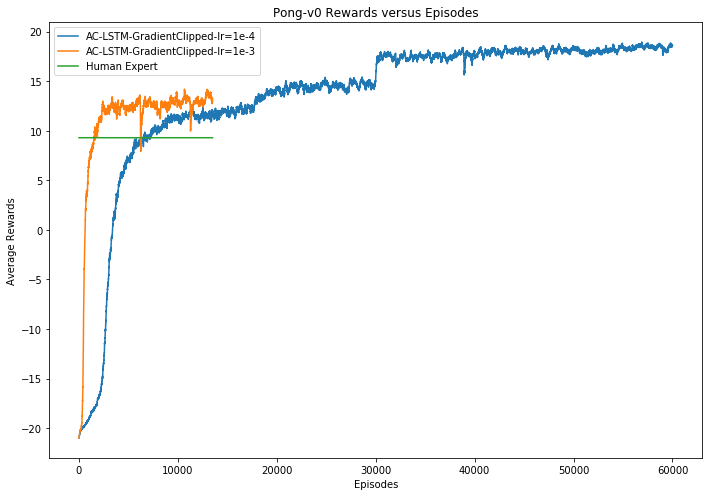

In [6]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'

data_file = './results/Pong-v0.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)
    
data_file = './results/Pong-v0 (ACL-episode-lr=1e-3-ep=13500).p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
print('Max. Running Reward (AC-LSTM lr=1e-4 clipped): {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_1) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-3 clipped): {:.3f}'.format(max(data_2)))
print('Episode achieving max. Running Reward: {}'.format(data_2.index(max(data_2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_2) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))

human = [human_scores[game] for _ in range(len(data_2))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-LSTM-GradientClipped-lr=1e-4')
plt.plot(data_2, label='AC-LSTM-GradientClipped-lr=1e-3')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Actor-Critic-LSTM (Truncated Backprop through Time - TBPTT)

Network Architecture is the same:  [ac_lstm_model.py](./ac_lstm_model.py)

Truncated Backprop Thru Time(TBPTT) 
* The general idea is based on Slide 41-44 of [CS231N_2017 Lecture 10](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf) 
* Run forward and backward through chunks of sequence vs whole sequence. While hidden values hx and cx are carried forward in time forever.  

We try chunks of different sizes (256,512 and 768 game steps) and clip the gradient with a high max_norm (2000-80000). 

In general, the agent learns better when chunk size is bigger. So far, they are still unable to outperform the agents that are trained through entire episodes.

Python code is located in:

[actor_critic_lstm-batch256.py](./actor_critic_lstm-batch256.py)  
[actor_critic_lstm-batch512.py](./actor_critic_lstm-batch512.py)  
[actor_critic_lstm-batch768.py](./actor_critic_lstm-batch768.py)  

## Bigger Chunk Size is Better

Max. Running Reward (AC-LSTM lr=1e-4 256-chunk): -2.771
Max. Running Reward (AC-LSTM lr=1e-4 512-chunk): 13.488
Max. Running Reward (AC-LSTM lr=1e-3 768-chunk): 10.989
Human Performance: 9.300


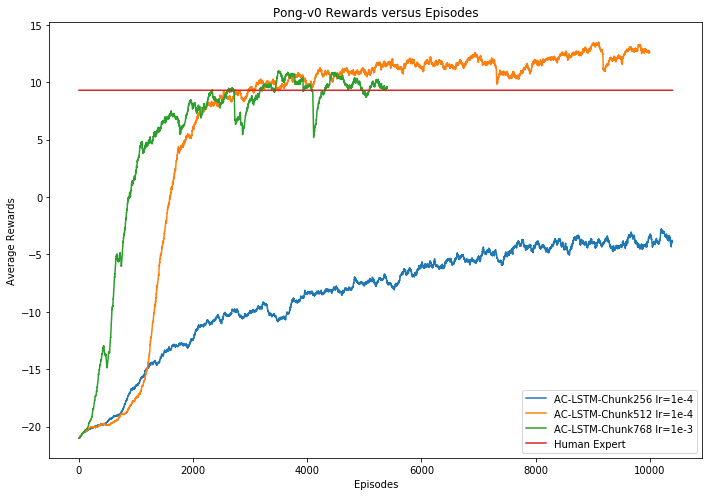

In [29]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/acl-batch_Pong-v0_cs_256.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)
    
data_file = './results/acl-batch_Pong-v0_cs_512.p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/acl-batch_Pong-v0_cs_768.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)
    
print('Max. Running Reward (AC-LSTM lr=1e-4 256-chunk): {:.3f}'.format(max(data_1)))
print('Max. Running Reward (AC-LSTM lr=1e-4 512-chunk): {:.3f}'.format(max(data_2)))
print('Max. Running Reward (AC-LSTM lr=1e-3 768-chunk): {:.3f}'.format(max(data_3)))
print('Human Performance: {:.3f}'.format(human_scores[game]))
    
human = [human_scores[game] for _ in range(len(data_1))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-LSTM-Chunk256 lr=1e-4')
plt.plot(data_2, label='AC-LSTM-Chunk512 lr=1e-4')
plt.plot(data_3, label='AC-LSTM-Chunk768 lr=1e-3')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()

plt.show()

## Full Episode Backprop Still Outperforms

Setting learning rate at 1e-3, we can see from the plot below that:  

* AC-LSTM (episode backprop or TBPTT) outperforms AC-noLSTM

Max. Running Reward (AC-LSTM lr=1e-3 episode backprop): 14.199
Episode achieving max. Running Reward: 10666
Episode achieving Human Performance: 1532
Max. Running Reward (AC-LSTM lr=1e-3 768-chunk): 10.989
Episode achieving max. Running Reward: 3498
Episode achieving Human Performance: 2334
Max. Running Reward (AC-No LSTM lr=1e-3): 11.210
Episode achieving max. Running Reward: 14497
Episode achieving Human Performance: 7485
Human Performance: 9.300


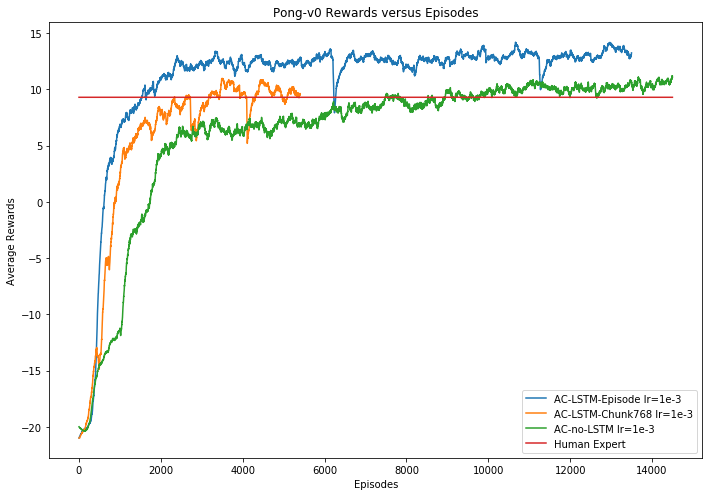

In [5]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0 (ACL-episode-lr=1e-3-ep=13500).p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

    
data_file = './results/acl-batch_Pong-v0_cs_768.p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/Pong-v0-chris.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)
    
print('Max. Running Reward (AC-LSTM lr=1e-3 episode backprop): {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_1) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-3 768-chunk): {:.3f}'.format(max(data_2)))
print('Episode achieving max. Running Reward: {}'.format(data_2.index(max(data_2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_2) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-No LSTM lr=1e-3): {:.3f}'.format(max(data_3)))
print('Episode achieving max. Running Reward: {}'.format(data_3.index(max(data_3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_3) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))

human = [human_scores[game] for _ in range(len(data_3))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-LSTM-Episode lr=1e-3')
plt.plot(data_2, label='AC-LSTM-Chunk768 lr=1e-3')
plt.plot(data_3, label='AC-no-LSTM lr=1e-3')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## AC-LSTM in Breakout

When we transfer our agents to learning the game of Breakout. We encountered some surprises:

* When we run AC-LSTM episode backprop at learning rate of 1e-3, it appears to hug the running reward curve of the AC-noLSTM. The outperformance is very minor compared to what we witness in Pong.

* AC-LSTM using TBPTT (512 and 768 chunk size) with learning rate 1e-4 outperforms AC-noLSTM at learning rate of 1e-3. AC-LSTM using TBPTT (768 chunk size) achieves a running reward of 75.6 after 60000 episodes.

* AC-LSTM with episode backprop at the learning rate of 1e-4 achieves the best result - running reward of 246 after 179K episodes.

Max. Running Reward (AC-No LSTM lr=1e-3): 48.96
Episode achieving max. Running Reward: 154934
Episode achieving Human Performance: 63307
Max. Running Reward (AC-LSTM lr=1e-3): 37.20
Episode achieving max. Running Reward: 54881
Episode achieving Human Performance: 30079
Max. Running Reward (AC-LSTM lr=1e-4): 253.50
Episode achieving max. Running Reward: 274616
Episode achieving Human Performance: 22201
Human Performance: 31.800


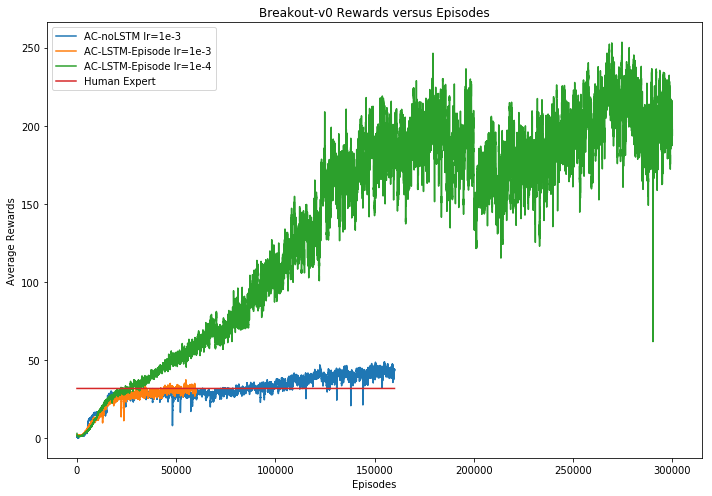

In [6]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
    
data_file = './results/Breakout-v0-chris.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)
    
data_file = './results/Breakout-v0(ACL-episode-lr=1e-3-ep=60000).p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/Breakout-v0.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)

print('Max. Running Reward (AC-No LSTM lr=1e-3): {:.2f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_1) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-3): {:.2f}'.format(max(data_2)))
print('Episode achieving max. Running Reward: {}'.format(data_2.index(max(data_2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_2) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-4): {:.2f}'.format(max(data_3)))
print('Episode achieving max. Running Reward: {}'.format(data_3.index(max(data_3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_3) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))
   
human = [human_scores[game] for _ in range(len(data_1))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-noLSTM lr=1e-3')
plt.plot(data_2, label='AC-LSTM-Episode lr=1e-3')
plt.plot(data_3, label='AC-LSTM-Episode lr=1e-4')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/ACL-vs-A3C-Breakout.png")
plt.show()

Max. Running Reward (AC-LSTM lr=1e-4 512-chunk): 26.96
Max. Running Reward (AC-LSTM lr=1e-4 768-chunk): 75.60
Human Performance: 31.800


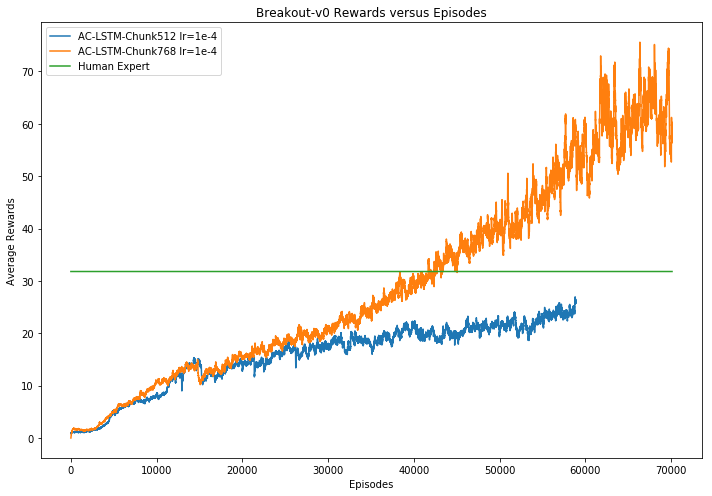

In [31]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
data_file = './results/acl-batch_Breakout-v0_cs_512.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

data_file = './results/acl-batch_Breakout-v0_cs_768.p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    

print('Max. Running Reward (AC-LSTM lr=1e-4 512-chunk): {:.2f}'.format(max(data_1)))
print('Max. Running Reward (AC-LSTM lr=1e-4 768-chunk): {:.2f}'.format(max(data_2)))
print('Human Performance: {:.3f}'.format(human_scores[game]))
   
human = [human_scores[game] for _ in range(len(data_2))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-LSTM-Chunk512 lr=1e-4')
plt.plot(data_2, label='AC-LSTM-Chunk768 lr=1e-4')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()

plt.savefig("./plots/TBPTT-Chunksizes-Breakout.png")
plt.show()

## Learning Rate

As in Pong, learning rate of 1e-4 outperforms learning rate of 1e-3 resulting in better long term performance.  

We train our agent with lr=1e-4 in 2 sessions of 100K episodes each, with the following temperature settings:  
* 1-100000: temp annealed from 1.8 to 1.0  
* 100001-200000: temp annealed from 1.0 to 0.8  

Max. Running Reward (AC-No LSTM lr=1e-3): 48.96
Episode achieving max. Running Reward: 154934
Episode achieving Human Performance: 63307
Max. Running Reward (AC-LSTM lr=1e-3): 37.20
Episode achieving max. Running Reward: 54881
Episode achieving Human Performance: 30079
Max. Running Reward (AC-LSTM lr=1e-4): 253.50
Episode achieving max. Running Reward: 274616
Episode achieving Human Performance: 22201
Human Performance: 31.800


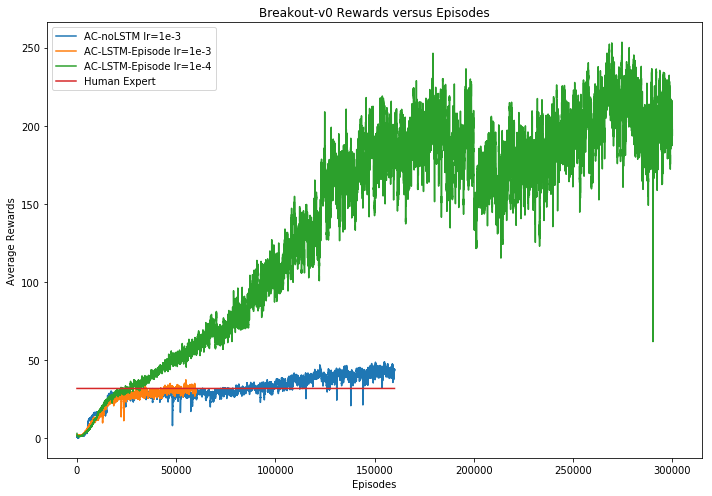

In [7]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
    
data_file = './results/Breakout-v0-chris.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)
    
data_file = './results/Breakout-v0(ACL-episode-lr=1e-3-ep=60000).p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)
    
data_file = './results/Breakout-v0.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)

print('Max. Running Reward (AC-No LSTM lr=1e-3): {:.2f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_1) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-3): {:.2f}'.format(max(data_2)))
print('Episode achieving max. Running Reward: {}'.format(data_2.index(max(data_2))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_2) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-4): {:.2f}'.format(max(data_3)))
print('Episode achieving max. Running Reward: {}'.format(data_3.index(max(data_3))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data_3) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))
   
human = [human_scores[game] for _ in range(len(data_1))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='AC-noLSTM lr=1e-3')
plt.plot(data_2, label='AC-LSTM-Episode lr=1e-3')
plt.plot(data_3, label='AC-LSTM-Episode lr=1e-4')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Policy Manifold

While we have no mathematical proof of this, we believe the policy manifold (if compressed into 3D) can be expressed as below:

* A dominant policy (central peak) is built on the foundation of lesser policies (outer rings).  
* An agent gets onto one of these outrings by learning a vital skill.
    * For example in Breakout, the agent first learn the skill of hitting the ball back.
* If the agent is skewed towards exploit and not explore (when temperature is low or learning rate is low), it will stay on the concentric ring and not move off of it.  
* Only by moving off the ring and taking some loss will the agent finds the way to move up the next higher concentric ring.  
* The successive mastering of key skills allows the agent to move up the successive rings towards the dominant policy.  

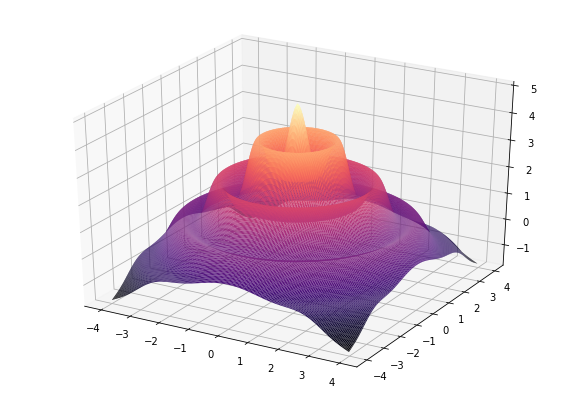

In [21]:
from mpl_toolkits.mplot3d import Axes3D
#Create some data to plot. 
y,x = np.mgrid[-4.:4.:.02, -4.:4.:.02]

r = np.sqrt(x**2 + y**2)

# z = np.exp((-x**2 - y**2)/1.2)*np.cos(2*np.pi*r/0.8)+np.exp((4.0-r)/6.0)
z = np.exp((-x**2 - y**2)/10)*np.cos(2*np.pi*r/1.2) + (4.0-r)

# plot data (x,y,z)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, rstride=2, cstride=2, shade=False, cmap="magma")
plt.show()

## Comparison against A3C (1-16 agents) - Pong

In this section, we compare our AC-LSTM network against the A3C network run in 1, 4 and 16 agent mode. We utilize the A3C codebase created by an NYU PHd (Ilya Kostrikov):

https://github.com/ikostrikov/pytorch-a3c

The results and initial summary is performed by fellow UCSD student Alex Potapov:

https://github.com/skinzer/cse253final/blob/GreatA1exander-patch-1/Graphs%20and%20Stuff.ipynb


### Generate Running Reward for A3C agents

In [7]:
# A3C 16-agent running reward

rewards16 = []
inFile =  open("./results/a3c-pong-16agent-running_rewards.txt",'r')

# Load the rewards
for row in inFile:
    rewards16.append(float(row.split(" ")[1][0:-1]))
#print(rewards16)

# Regenerate running rewards
running_reward16 = None
running_rewards16 = []
for item in rewards16:
    if running_reward16 == None:
        running_reward16 = item
    else:
        running_reward16 = running_reward16*.99+item*.01
    running_rewards16.append(running_reward16)

    #print(running_)
inFile.close()

# A3C 4-agent running reward

rewards4 = []
inFile =  open("./results/a3c-pong-4agent-running_rewards.txt",'r')
for row in inFile:
    rewards4.append(float(row.split(" ")[1][0:-1]))
running_reward4 = None
running_rewards4 = []
for item in rewards4:
    if running_reward4 == None:
        running_reward4 = item
    else:
        running_reward4 = running_reward4*.99+item*.01
    running_rewards4.append(running_reward4)
#print(running_)
inFile.close()

# A3C 1-agent running reward

rewards1 = []
inFile =  open("./results/a3c-pong-1agent-running_rewards.txt",'r')
for row in inFile:
    rewards1.append(float(row.split(" ")[1][0:-1]))
running_reward1 = None
running_rewards1 = []
for item in rewards1:
    if running_reward1 == None:
        running_reward1 = item
    else:
        running_reward1 = running_reward1*.99+item*.01
    running_rewards1.append(running_reward1)
inFile.close()

## Performance Against A3C

Our best model achieves commparable long term optimal performance relative to A3C agents.

Max. Running Reward (1 Agent A3C): 18.61  
Max. Running Reward (4 Agent A3C): 15.75  
Max. Running Reward (16 Agent A3C): 18.77  
Max. Running Reward (AC-LSTM lr=1e-4): 18.1  
Human Performance: 9.300  

It just takes much longer for our agent to attain peak performance.

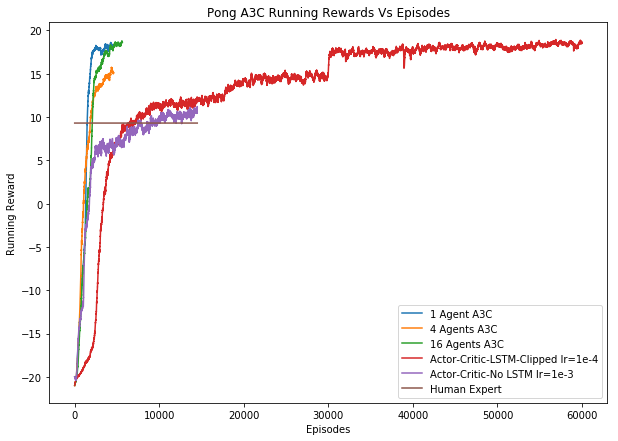

Max. Running Reward (1 Agent A3C): 18.61
Episode achieving max. Running Reward: 4257
Episode achieving Human Performance: 1477
Max. Running Reward (4 Agent A3C): 15.75
Episode achieving max. Running Reward: 4354
Episode achieving Human Performance: 1828
Max. Running Reward (16 Agent A3C): 18.77
Episode achieving max. Running Reward: 5602
Episode achieving Human Performance: 2078
Max. Running Reward (AC-LSTM lr=1e-4): 18.94
Episode achieving max. Running Reward: 56896
Episode achieving Human Performance: 6371
Episode achieving max. Running Reward: 14497
Max. Running Reward (AC-No LSTM lr=1e-3): 11.21
Episode achieving Human Performance: 7485
Human Performance: 9.300


In [8]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
plt.figure(figsize=(10, 7))
plt.plot( np.arange(0, len(running_rewards1), 1),running_rewards1, label = '1 Agent A3C')
plt.plot( np.arange(0, len(running_rewards4), 1),running_rewards4, label = '4 Agents A3C')
plt.plot( np.arange(0, len(running_rewards16), 1),running_rewards16,label = '16 Agents A3C')

data_file = './results/Pong-v0.p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1, label='Actor-Critic-LSTM-Clipped lr=1e-4')

data_file = './results/Pong-v0-AC-noLSTM.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2, label='Actor-Critic-No LSTM lr=1e-3')

human = [human_scores[game] for _ in range(len(data2))]
plt.plot(human, label='Human Expert')

plt.title("Pong A3C Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/ACL-vs-A3C-Pong.png")
plt.show()


print('Max. Running Reward (1 Agent A3C): {:.2f}'.format(max(running_rewards1)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards1.index(max(running_rewards1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards1) if v > human_scores[game]][0]))

print('Max. Running Reward (4 Agent A3C): {:.2f}'.format(max(running_rewards4)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards4.index(max(running_rewards4))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards4) if v > human_scores[game]][0]))

print('Max. Running Reward (16 Agent A3C): {:.2f}'.format(max(running_rewards16)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards16.index(max(running_rewards16))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards16) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-4): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))

print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Max. Running Reward (AC-No LSTM lr=1e-3): {:.2f}'.format(max(data2)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))

## Comparison against A3C (1-16 agents) - Breakout

When we compare our AC-LSTM agent against A3C in Breakout. Our agent trained at lr=1e-4 is outperforming the A3C agents. 

We have not run these A3C agents for long enough episodes. And they have not be hyperparameter-tuned for Breakout.

In [10]:
# A3C 16-agent running reward

rewards16 = []
inFile =  open("./results/a3c-breakout-16agent-running_rewards.txt",'r')

# Load the rewards
for row in inFile:
    rewards16.append(float(row.split(" ")[1][0:-1]))
#print(rewards16)

# Regenerate running rewards
running_reward16 = None
running_rewards16 = []
for item in rewards16:
    if running_reward16 == None:
        running_reward16 = item
    else:
        running_reward16 = running_reward16*.99+item*.01
    running_rewards16.append(running_reward16)

    #print(running_)
inFile.close()

# A3C 4-agent running reward

rewards4 = []
inFile =  open("./results/a3c-breakout-4agent-running_rewards.txt",'r')
for row in inFile:
    rewards4.append(float(row.split(" ")[1][0:-1]))
running_reward4 = None
running_rewards4 = []
for item in rewards4:
    if running_reward4 == None:
        running_reward4 = item
    else:
        running_reward4 = running_reward4*.99+item*.01
    running_rewards4.append(running_reward4)
#print(running_)
inFile.close()

# A3C 1-agent running reward

rewards1 = []
inFile =  open("./results/a3c-breakout-1agent-running_rewards.txt",'r')
for row in inFile:
    rewards1.append(float(row.split(" ")[1][0:-1]))
running_reward1 = None
running_rewards1 = []
for item in rewards1:
    if running_reward1 == None:
        running_reward1 = item
    else:
        running_reward1 = running_reward1*.99+item*.01
    running_rewards1.append(running_reward1)
inFile.close()

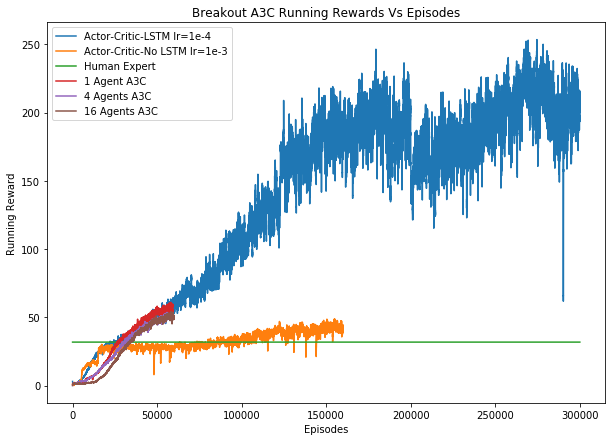

Max. Running Reward (1 Agent A3C): 60.97
Episode achieving max. Running Reward: 58085
Episode achieving Human Performance: 26693
Max. Running Reward (4 Agent A3C): 53.58
Episode achieving max. Running Reward: 55853
Episode achieving Human Performance: 29467
Max. Running Reward (16 Agent A3C): 54.26
Episode achieving max. Running Reward: 58024
Episode achieving Human Performance: 33548
Max. Running Reward (AC-LSTM lr=1e-4): 253.50
Episode achieving max. Running Reward: 274616
Episode achieving Human Performance: 22201
Episode achieving max. Running Reward: 154934
Max. Running Reward (AC-No LSTM lr=1e-3): 48.96
Episode achieving Human Performance: 63307
Human Performance: 31.800


In [11]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Breakout-v0'
plt.figure(figsize=(10, 7))

data_file = './results/Breakout-v0.p'.format(game)
with open(data_file, 'rb') as f:
    data1 = pickle.load(f)

plt.plot(data1, label='Actor-Critic-LSTM lr=1e-4')

data_file = './results/Breakout-v0-chris.p'.format(game)
with open(data_file, 'rb') as f:
    data2 = pickle.load(f)

plt.plot(data2[:len(data1)], label='Actor-Critic-No LSTM lr=1e-3')

human = [human_scores[game] for _ in range(len(data1))]
plt.plot(human, label='Human Expert')

plt.plot( np.arange(0, len(running_rewards1), 1),running_rewards1, label = '1 Agent A3C')
plt.plot( np.arange(0, len(running_rewards4), 1),running_rewards4, label = '4 Agents A3C')
plt.plot( np.arange(0, len(running_rewards16), 1),running_rewards16,label = '16 Agents A3C')

plt.title("Breakout A3C Running Rewards Vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")
plt.legend()
plt.savefig("./plots/ACL-vs-A3C-Breakout.png")
plt.show()

print('Max. Running Reward (1 Agent A3C): {:.2f}'.format(max(running_rewards1)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards1.index(max(running_rewards1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards1) if v > human_scores[game]][0]))

print('Max. Running Reward (4 Agent A3C): {:.2f}'.format(max(running_rewards4)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards4.index(max(running_rewards4))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards4) if v > human_scores[game]][0]))

print('Max. Running Reward (16 Agent A3C): {:.2f}'.format(max(running_rewards16)))
print('Episode achieving max. Running Reward: {}'.format(running_rewards16.index(max(running_rewards16))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(running_rewards16) if v > human_scores[game]][0]))

print('Max. Running Reward (AC-LSTM lr=1e-4): {:.2f}'.format(max(data1)))
print('Episode achieving max. Running Reward: {}'.format(data1.index(max(data1))))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data1) if v > human_scores[game]][0]))

print('Episode achieving max. Running Reward: {}'.format(data2.index(max(data2))))
print('Max. Running Reward (AC-No LSTM lr=1e-3): {:.2f}'.format(max(data2)))
print('Episode achieving Human Performance: {}'.format([i for i,v in enumerate(data2) if v > human_scores[game]][0]))

print('Human Performance: {:.3f}'.format(human_scores[game]))